In [8]:
onGPU = True
gpuFraction = 1.0

In [9]:
if onGPU:
    import setGPU

In [10]:
if onGPU and gpuFraction<1.0:
    # limit GPU usage
    import sys
    import tensorflow as tf
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpuFraction)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
    import keras
    from keras import backend as K
    K.set_session(sess)
    print('using gpu memory fraction: '+str(gpuFraction))

In [11]:
%matplotlib inline

In [12]:
import h5py
import glob
import numpy as np

# Prepare train and test samples

In [22]:
import glob
import sys
X = np.array([])
Y = np.array([])
for fileIN in glob.glob("/data/ML/mpierini/hls-fml/jetImage*_30*.h5"):
    print(fileIN)
    f = h5py.File(fileIN, 'r')
    myFeatures = np.array(f.get('jets')[:,[12, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 52]])
    myTarget = np.array(f.get('jets')[0:,-6:-1])
    X = np.concatenate([X,myFeatures], axis = 0) if X.size else myFeatures
    Y = np.concatenate([Y,myTarget], axis = 0) if Y.size else myTarget
    print(X.shape, Y.shape)

/data/ML/mpierini/hls-fml/jetImage_697255_1393473_30.h5
(10000, 16) (10000, 5)
/data/ML/mpierini/hls-fml/jetImage_0_697346_30.h5
(20000, 16) (20000, 5)
/data/ML/mpierini/hls-fml/jetImage_2887047_3523866_30.h5
(30000, 16) (30000, 5)
/data/ML/mpierini/hls-fml/jetImage_4333174_4754296_30.h5
(40000, 16) (40000, 5)
/data/ML/mpierini/hls-fml/jetImage_3523808_3927485_30.h5
(50000, 16) (50000, 5)
/data/ML/mpierini/hls-fml/jetImage_1393449_1801177_30.h5
(60000, 16) (60000, 5)
/data/ML/mpierini/hls-fml/jetImage_3927453_4333213_30.h5
(70000, 16) (70000, 5)
/data/ML/mpierini/hls-fml/jetImage_1801094_2226542_30.h5
(80000, 16) (80000, 5)


In [46]:
print(Y[0,:])
# target should be such that 1->1 and 0->-1
Y = Y*2-1.
print(Y[0,:])

[1. 0. 0. 0. 0.]
[ 1. -1. -1. -1. -1.]


In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

In [48]:
# shuffle datasets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(53600, 16) (26400, 16) (53600, 5) (26400, 5)


# build the model

In [120]:
# keras imports
from keras.models import Model, Sequential
from keras.layers import Input, BatchNormalization, Activation
from keras.utils import plot_model
from keras import regularizers
from keras import backend as K
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
#
from quantized_layers import BinaryDense, TernaryDense, QuantizedDense
from quantized_ops import binary_tanh

# Binary Networks 

In [133]:
nclasses = 5

In [152]:
model = Sequential()
    
4
model.add(BinaryDense(64, H=1, use_bias=False, name='fc1'))
model.add(BatchNormalization(epsilon=1e-6, momentum=0.9, name='bn1'))
model.add(Activation('relu', name='act{}'.format(1)))
    
model.add(BinaryDense(32, H=1, use_bias=False, name='fc2'))  
model.add(BatchNormalization(epsilon=1e-6, momentum=0.9, name='bn2'))
model.add(Activation('relu', name='act{}'.format(2)))  
   
model.add(BinaryDense(32, H=1, use_bias=False, name='fc3'))   
model.add(BatchNormalization(epsilon=1e-6, momentum=0.9, name='bn3'))
model.add(Activation('relu', name='act{}'.format(3)))  
       
model.add(BinaryDense(nclasses, H=1, use_bias=False, name='output'))
model.add(BatchNormalization(epsilon=1e-6, momentum=0.9, name='bn'))

In [153]:
model.compile(loss='squared_hinge', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bn0 (BatchNormalization)     (None, 16)                64        
_________________________________________________________________
fc1 (BinaryDense)            (None, 64)                1024      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 64)                256       
_________________________________________________________________
act1 (Activation)            (None, 64)                0         
_________________________________________________________________
fc2 (BinaryDense)            (None, 32)                2048      
_________________________________________________________________
bn2 (BatchNormalization)     (None, 32)                128       
_________________________________________________________________
act2 (Activation)            (None, 32)                0         
__________

In [154]:
n_epochs = 400
batch_size = 128
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_test, y_test),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 53600 samples, validate on 26400 samples
Epoch 1/400
 - 5s - loss: 0.9229 - val_loss: 0.6007
Epoch 2/400
 - 2s - loss: 0.5121 - val_loss: 0.4488
Epoch 3/400
 - 4s - loss: 0.4316 - val_loss: 0.4160
Epoch 4/400
 - 5s - loss: 0.4046 - val_loss: 0.4006
Epoch 5/400
 - 6s - loss: 0.3927 - val_loss: 0.3731
Epoch 6/400
 - 6s - loss: 0.3817 - val_loss: 0.3648
Epoch 7/400
 - 5s - loss: 0.3761 - val_loss: 0.3549
Epoch 8/400
 - 4s - loss: 0.3644 - val_loss: 0.3507
Epoch 9/400
 - 4s - loss: 0.3578 - val_loss: 0.3309
Epoch 10/400
 - 5s - loss: 0.3543 - val_loss: 0.3362
Epoch 11/400
 - 6s - loss: 0.3528 - val_loss: 0.3382

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 12/400
 - 2s - loss: 0.3434 - val_loss: 0.3251
Epoch 13/400
 - 4s - loss: 0.3450 - val_loss: 0.3250
Epoch 14/400
 - 5s - loss: 0.3438 - val_loss: 0.3381

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 15/400
 - 6s - loss: 0.3420 - val_loss: 0.3279


In [156]:
import matplotlib.pyplot as plt
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()
#

# Check Performances

In [157]:
labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t']

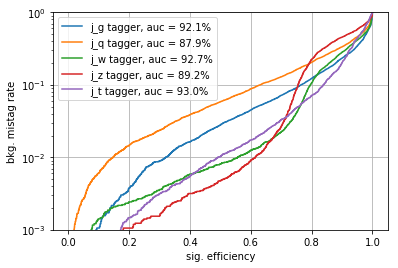

In [160]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_test = model.predict(X_test)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_test[:,i]
        df[label + '_pred'] = predict_test[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))
plt.show()